# Configure font

In [1]:
# Configure Arial as the default font in all figures

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm


arial_font_path = '/PATH/TO/ARIAL/FONT/arial.ttf'

fm.fontManager.addfont(arial_font_path)

plt.rcParams['font.family'] = 'Arial'

# Path to Zenodo files folder

In [1]:
path = 'PATH/TO/ZENODO/FILES/FOLDER'

# Figure S12

## Panel A

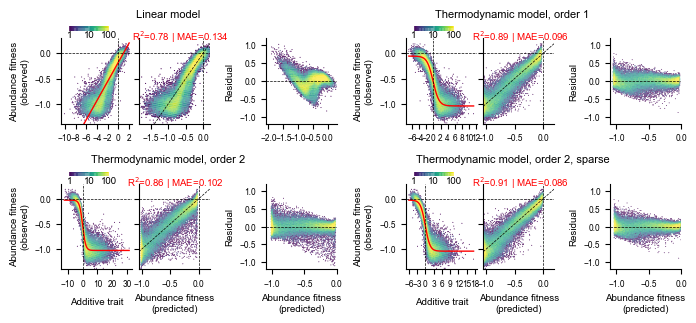

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr
import matplotlib.ticker as ticker
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
import matplotlib.gridspec as gridspec
from scipy.optimize import curve_fit
from seaborn import kdeplot

def sigmoid(x, L ,x0, k, b): ##https://stackoverflow.com/questions/55725139/fit-sigmoid-function-s-shape-curve-to-data-using-python
    z = L / (1 + np.exp(-k*(x-x0))) + b
    return (z)
    
def normalize(values, bounds):
        return [bounds['desired']['lower'] + (x - bounds['actual']['lower']) * (bounds['desired']['upper'] - bounds['desired']['lower']) / (bounds['actual']['upper'] - bounds['actual']['lower']) for x in values]

model_names = {'1_linear': 'Linear', '1':'1', '2':'2', '2_sparse_regularized':'2'}
tasks = {'1_linear': '1', '1':'1', '2':'1', '2_sparse_regularized':'4'}

model_title = {'1_linear': 'Linear model', '1':'Thermodynamic model, order 1', '2':'Thermodynamic model, order 2', '2_sparse_regularized':'Thermodynamic model, order 2, sparse'}

model_xlims={'1_linear':[-1.85,0.2], '1':[-1.05,0.2],'2':[-1.05,0.2],'2_sparse_regularized':[-1.05,0.2]}
res_xlims = {'1_linear':[-2.1,0.3],   '1':[-1.1,0],  '2':[-1.1,0],'2_sparse_regularized':[-1.1,0]}
model_ylims={'1_linear':[-1.4,0.3],  '1':[-1.4,0.3], '2':[-1.4,0.3],'2_sparse_regularized':[-1.4,0.3]}
model_ticks={'1_linear':2,           '1':2,          '2':10,'2_sparse_regularized':3}

fig = plt.figure(figsize=(8, 3))
outer = gridspec.GridSpec(2, 2, wspace=0.25, hspace=0.7)

for lib_idx, dataset in enumerate(list(model_names.keys())):
    
    # --- Define the position in the big figure ---
    inner = gridspec.GridSpecFromSubplotSpec(
        1, 4,  # 4 stacked subplots
        subplot_spec=outer[lib_idx],
        width_ratios=[1,1,0.6,1],
        hspace=0.15,
        wspace=0.1
    )

    ################################
    #  LOAD PHENOTYPE PREDICTIONS  #
    ################################
    
    predicted_phenotypes = pd.read_csv(path+'Fig5/mochi/Surface/RandomFYN_surface_order'+dataset+'/task_'+tasks[dataset]+'/predictions/predicted_phenotypes_all.txt',
                                      sep='\t', lineterminator='\n', low_memory=False)
    
    predicted_phenotypes['mean_additive_trait']=predicted_phenotypes[['fold_1_additive_trait0','fold_2_additive_trait0','fold_3_additive_trait0','fold_4_additive_trait0','fold_5_additive_trait0','fold_6_additive_trait0','fold_7_additive_trait0','fold_8_additive_trait0','fold_9_additive_trait0','fold_10_additive_trait0']].mean(axis=1)
    
    mask = predicted_phenotypes['WT'] != True
    predicted_phenotypes.loc[mask, 'predicted_fitness'] = predicted_phenotypes.loc[mask].apply(lambda row: row['fold_' + str(int(row['Fold']))],axis=1)
    
    fyn_wt = 'TLFVALYDYEARTEDDLSFHKGEKFQILNSSEGDWWEARSLTTGETGYIPSNYVAPV'

    # Normalize data in the -1 to 0 range
    
    reference=predicted_phenotypes.loc[predicted_phenotypes['WT']==True].iloc[0]['aa_seq']
       
    norm_fig = plt.figure(figsize=(0,0))
    lines = kdeplot(data=predicted_phenotypes.loc[predicted_phenotypes['fitness']<-1.2],x='fitness',linewidth=1).get_lines()
    for line in lines:
        x, y = line.get_data()
        mode=(x[np.argmax(y)])
    plt.close()
    
    predicted_phenotypes['fitness']=normalize(list(predicted_phenotypes['fitness']),{'actual': {'lower': mode, 'upper': predicted_phenotypes.loc[predicted_phenotypes['aa_seq']==reference]['fitness'].iloc[0]}, 'desired': {'lower': -1, 'upper': 0}})

    predicted_phenotypes['predicted_fitness']=normalize(list(predicted_phenotypes['predicted_fitness']),{'actual': {'lower': mode, 'upper': 0}, 'desired': {'lower': -1, 'upper': 0}})

    
    ####################################
    #  PLOT FITNESS VS ADDITIVE TRAIT  #
    ####################################

    ax0 = plt.Subplot(fig, inner[0])
    fig.add_subplot(ax0)

    ax1 = plt.Subplot(fig, inner[1],sharey=ax0)
    fig.add_subplot(ax1)
    
    ax2 = plt.Subplot(fig, inner[3])
    fig.add_subplot(ax2)

    
    predicted_phenotypes=predicted_phenotypes.sort_values(['mean_additive_trait'])
    
    
    if model_names[dataset]=='Linear':
        x=predicted_phenotypes[['mean_additive_trait']].to_numpy()
        y=predicted_phenotypes[['fitness']].to_numpy()
        model = LinearRegression()
        model.fit(x, y)
        
        y_pred = model.predict(x)
        r2 = r2_score(y,y_pred)
        r,p = pearsonr(y.ravel(),y_pred.ravel())
        hbin=ax0.hexbin(predicted_phenotypes['mean_additive_trait'],predicted_phenotypes['fitness'],bins='log',gridsize=75, cmap='viridis',rasterized=True,linewidths=0, vmax=100)
        ax0.plot(x, y_pred, '-',c='r', linewidth=1)
    else:
        x=predicted_phenotypes['mean_additive_trait']
        y=predicted_phenotypes['fitness']
        p0 = [max(y), np.median(x),0,min(y)] # this is an mandatory initial guess
        popt, pcov = curve_fit(sigmoid, x, y,p0, method='lm', maxfev=10000)
        x_range = np.linspace(x.iloc[0],x.iloc[-1],1000)
        y_sig = sigmoid(x_range, *popt)
        deriv = np.diff(y_sig)/np.diff(x_range)
        hbin=ax0.hexbin(predicted_phenotypes['mean_additive_trait'],predicted_phenotypes['fitness'],bins='log',gridsize=75, cmap='viridis',rasterized=True,linewidths=0, vmax=100)
        ax0.plot(x_range, y_sig, '-',c='r', linewidth=1)
    
    ax0.axvline(0, ls='--', color='black', linewidth=0.5)
    ax0.axhline(0,  ls='--', color='black', linewidth=0.5)
    ax0.set_xlabel('Additive trait', fontsize=7,labelpad=6.5)
    ax0.set_ylabel('Abundance fitness\n(observed)', fontsize=7)
    ax0.tick_params(axis='y', labelsize=6)
    ax0.xaxis.set_major_locator(MultipleLocator(model_ticks[dataset]))
    ax0.tick_params(axis='x', labelsize=6,rotation=0)
    ax0.set_yticks(np.arange(-2,1,0.5))
    #ax0.set_ylim(model_xlims[dataset][0],model_xlims[dataset][1])
    ax0.set_ylim(model_xlims[dataset][0],model_xlims[dataset][1])
    ax0.set_rasterization_zorder(0)
    ax0.spines[['top','right']].set_visible(False)
    fmt = '%1.f'

    # Get positions
    bbox0 = ax0.get_position()
    bbox1 = ax1.get_position()
    
    # Create a colorbar axis centered between ax0 and ax1
    cbar_left = bbox0.x0 + 0.01
    cbar_bottom = bbox0.y1 + 0.025   # a little bit above
    cbar_width = 0.05
    cbar_height = 0.015              # small height for horizontal colorbar
    
    cax = fig.add_axes([cbar_left, cbar_bottom, cbar_width, cbar_height])
    
    # Now create colorbar in the dynamic cax
    cb = fig.colorbar(hbin, ax=ax0, cax=cax, orientation='horizontal')
    cb.outline.set_visible(False)
    cb.ax.tick_params(axis='x', which='both', direction='in', color='white', width=0.25, labelsize=6)
    cb.ax.xaxis.set_tick_params(pad=0)
    cb.set_ticks([1,10,100])
    cb.set_ticklabels([1,10,100], fontsize=7)
    
    
    ########################################
    #  PLOT OBSERVED VS PREDICTED FITNESS  #
    ########################################
    
    y = predicted_phenotypes.loc[predicted_phenotypes['Nham_aa']>0][['fitness']].to_numpy()
    x = predicted_phenotypes.loc[predicted_phenotypes['Nham_aa']>0][['predicted_fitness']].to_numpy()
    model = LinearRegression()
    model.fit(x,y)
    y_pred = model.predict(x)
    
    #fig, ax = plt.subplots(figsize=(1,1))
    hbin=ax1.hexbin(x=predicted_phenotypes['predicted_fitness'].loc[predicted_phenotypes['Nham_aa']>0],y=predicted_phenotypes['fitness'].loc[predicted_phenotypes['Nham_aa']>0],bins='log',gridsize=75,rasterized=True,linewidths=0,vmax=100)
    ax1.axline((0.1, 0.1), slope=1, linestyle = "dashed", color = 'black',lw=0.5)
    
    
    ax1.axvline(0, ls='--', color='black', lw=0.5)
    ax1.axhline(0, ls='--', color='black', lw=0.5)
    ax1.text(model_xlims[dataset][0]-0.2,0.25,'\nR$^2$='+str(round(r2_score(y,y_pred),2))+' | MAE='+str(round(mean_absolute_error(y,y_pred),3)),fontsize=7, color='r')
    ax1.set_xlabel('Abundance fitness\n(predicted)', fontsize=7)
    ax1.set_ylabel('', fontsize=7)
    ax1.tick_params(axis='y', labelsize=6)
    ax1.set_xticks(np.arange(-2,1,0.5))
    ax1.tick_params(axis='x', labelsize=6,rotation=0)
    ax1.set_xlim(model_xlims[dataset][0],model_xlims[dataset][1])
    ax1.set_yticks(np.arange(-2,1,0.5))
    ax1.set_xlim(model_xlims[dataset][0],model_xlims[dataset][1])
    ax1.set_ylim(model_ylims[dataset][0],model_ylims[dataset][1])
    #ax.set_xlim(-1.7,0.2)
    #ax.set_yticks(np.arange(-4,1,1))
    ax1.set_rasterization_zorder(0)
    ax1.spines[['top','right']].set_visible(False)

    ####################
    #  PLOT RESUDIALS  #
    ####################

    residual = (y - y_pred)
    
    hbin=ax2.hexbin(x=predicted_phenotypes.loc[predicted_phenotypes['Nham_aa']>0][['predicted_fitness']].to_numpy(),y=residual,bins='log',gridsize=75,rasterized=True,linewidths=0,vmax=100)

    ax2.axhline(0, ls='--', color='black', lw=0.5)
    ax2.set_xlabel('Abundance fitness\n(predicted)', fontsize=7)
    ax2.set_ylabel('Residual', fontsize=7)
    ax2.tick_params(axis='y', labelsize=6)
    ax2.set_xticks(np.arange(-2,1,0.5))
    ax2.tick_params(axis='x', labelsize=6,rotation=0)
    ax2.set_xlim(model_xlims[dataset][0],model_xlims[dataset][1])
    ax2.set_yticks(np.arange(-2,2,0.5))
    ax2.set_ylim(-1.2,1.2)
    ax2.set_xlim(res_xlims[dataset][0],res_xlims[dataset][1])
    #ax1.set_ylim(model_ylims[dataset][0],model_ylims[dataset][1])
    #ax.set_xlim(-1.7,0.2)
    #ax.set_yticks(np.arange(-4,1,1))
    ax2.set_rasterization_zorder(0)
    ax2.spines[['top','right']].set_visible(False)
    
    ax0.set_title(model_title[dataset], fontsize=8, x=1.5,pad=15)

    # Which column and row?
    is_left_col = (lib_idx % 2 == 0)
    is_bottom_row = (lib_idx // 2 == 1)
    
    # Y-labels and Y-ticks
    if is_left_col:
        ax0.set_ylabel('Abundance fitness\n(observed)', fontsize=7)
        ax0.tick_params(axis='y', labelsize=6)
        ax1.tick_params(labelleft=False)  # Hide only the ticks, but leave ax0 intact
        ax2.tick_params(labelleft=True)  # Hide only the ticks, but leave ax0 intact
    else:
        ax0.set_ylabel('Abundance fitness\n(observed)', fontsize=7)
        ax0.tick_params(axis='y', labelsize=6)
        ax1.tick_params(labelleft=False)  # Hide ticks on ax1
        ax2.tick_params(labelleft=True)  # Hide ticks on ax1
    
    # X-labels
    if is_bottom_row:
        ax0.set_xlabel('Additive trait', fontsize=7, labelpad=6.5)
        ax1.set_xlabel('Abundance fitness\n(predicted)', fontsize=7)
        ax2.set_xlabel('Abundance fitness\n(predicted)', fontsize=7)
    else:
        ax0.set_xlabel('')
        ax1.set_xlabel('')
        ax2.set_xlabel('')
#    ax0.text(0.02, 0.02, f'n={len(predicted_phenotypes):,}', transform=ax0.transAxes, fontsize=8, va='bottom', ha='left')

plt.show()

## Panel B

In [4]:
import pandas as pd
## LOAD ROCKLIN DATA ##

rocklin_query_protein = pd.read_csv(path+'Fig3/FYN_Tsuboyama.txt',sep='\t',index_col=0)

## LOAD THERMOMUT DATA ##

thermomut = pd.read_csv(path+'Fig3/FYN_thermomut.txt',sep='\t', index_col=0)

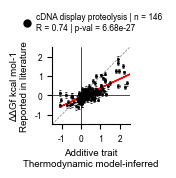

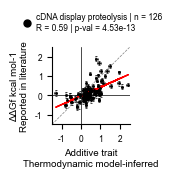

In [5]:
### Additive trait plots

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr
from matplotlib.lines import Line2D
import math

plt.rcParams['font.family'] = 'Arial'

model_names = {'order1':'1', '2_sparse_regularized':'2_sparse_regularized'}
tasks = {'order1':'1', '2_sparse_regularized':'4'}

for mochi_model in model_names.keys():
    ## LOAD MODEL COEFFICIENTS ##
    coefs = pd.read_csv(path+'Fig5/mochi/Surface/RandomFYN_surface_order'+model_names[mochi_model]+'/task_'+tasks[mochi_model]+'/weights/weights_Folding.txt',
                               sep='\t')

    coefs.rename(columns={'ci95_kcal/mol':'ci95_kcal_mol'}, inplace=True)
    for index, row in coefs.iterrows():
        if row.id_ref =='WT':
            coefs.at[index,'order']=0
        else:
            coefs.at[index,'order']=len(row.id.split('_'))
    
    firstorderterms=coefs.loc[coefs['order']==1].copy()
    
    rocklin_merge = firstorderterms[['id', 'mean', 'std', 'order']].merge(
        rocklin_query_protein.loc[rocklin_query_protein['redundant_single']==False][['mutations', 'deltaG', 'deltaG_95CI']], 
        left_on='id', right_on='mutations'
    )
    rocklin_merge.set_index('id', inplace=True)
    del rocklin_merge['mutations']
    
    rocklins_wt_dg = -1*rocklin_query_protein.loc[rocklin_query_protein['name']=='1A0N.pdb'].iloc[0]['deltaG']
    rocklins_wt_dg_SE = (-1*rocklin_query_protein.loc[rocklin_query_protein['name']=='1A0N.pdb'].iloc[0]['deltaG_95CI'])/1.96
    alberts_wt_dg = float(coefs.loc[coefs['id']=='WT'].iloc[0]['mean'])
    for index, row in rocklin_merge.iterrows():
        variant_dg_SE = (-1*row.deltaG_95CI)/1.96
        variant_ddg_SE = math.sqrt((rocklins_wt_dg_SE**2)+(variant_dg_SE**2))
        rocklin_merge.at[index,'rocklin_dGf'] = -1 *row.deltaG
        rocklin_merge.at[index,'rocklin_ddGf'] = (-1 *row.deltaG) - rocklins_wt_dg
        rocklin_merge.at[index,'rocklin_ddGf_SE'] = variant_ddg_SE
        rocklin_merge.at[index,'rocklin_ddGf_CI95'] = variant_ddg_SE * 1.96
        rocklin_merge.at[index,'albert_dGf'] = alberts_wt_dg + row['mean']
    
#    thermomut_merge = rocklin_merge.merge(thermomut.loc[(thermomut['order'] == 1) & (thermomut['ΔΔG'].notna())][['ΔΔG','Mut1','order']], left_on='id',right_on='Mut1').drop_duplicates().set_index('Mut1').sort_values('mean').copy()
    thermomut_merge = firstorderterms[['id', 'mean', 'std','order']].merge(thermomut.loc[(thermomut['order'] == 1) & (thermomut['ΔΔG'].notna())][['ΔΔG','Mut1','order']], left_on='id',right_on='Mut1').drop_duplicates().set_index('Mut1').sort_values('mean').copy()
    if len(thermomut_merge)>0:
        thermomut_avg = pd.DataFrame()
        for index, row in thermomut_merge.value_counts('id').to_frame().iterrows():
            multiple_measurements = thermomut_merge.loc[thermomut_merge['id']==index]
            thermomut_avg.at[index,'id']=index
            thermomut_avg.at[index,'mean']=multiple_measurements.iloc[0]['mean']
            thermomut_avg.at[index,'std']=multiple_measurements.iloc[0]['std']
            thermomut_avg.at[index,'order_x']=multiple_measurements.iloc[0]['order_x']
            thermomut_avg.at[index,'ΔΔG']=multiple_measurements['ΔΔG'].mean()
            thermomut_avg.at[index,'iv_std']=multiple_measurements['ΔΔG'].std()
        thermomut_core = thermomut_avg[['ΔΔG','iv_std','mean','std','order_x']].copy()
        thermomut_core = thermomut_core.rename(columns={'ΔΔG':'prev_ddG','iv_std':'prev_SE','order_x':'Nham'})
        thermomut_core['Dataset']='ThermoMutDB'
    rocklin_merge = rocklin_merge.rename(columns={'rocklin_ddGf':'prev_ddG','rocklin_ddGf_SE':'prev_SE','order':'Nham'})
    rocklin_merge['Dataset']='cDNA display proteolysis'
    if len(thermomut_merge)>0:
        all_core_ddGf_validations = pd.concat([thermomut_core[['prev_ddG','prev_SE','mean','std','Dataset','Nham']],rocklin_merge[['prev_ddG','prev_SE','mean','std','Dataset','Nham']]],axis=0)
    else:
        all_core_ddGf_validations = rocklin_merge[['prev_ddG','prev_SE','mean','std','Dataset','Nham']].copy()

    fig, ax = plt.subplots(figsize=(1, 1))

    palette = {'ThermoMutDB': '#BB202E', 'cDNA display proteolysis': 'black'}
    palette = {'cDNA display proteolysis': 'black'}
    # Scatterplot
    scatter = sns.scatterplot(
        x='mean', 
        y='prev_ddG', 
        data=all_core_ddGf_validations, 
        hue='Dataset', 
        palette=palette, 
        ax=ax, 
        s=0,
        edgecolor='k', 
        linewidth=0.1
    )

    for dataset in palette.keys():
        plt.errorbar(
            all_core_ddGf_validations.loc[all_core_ddGf_validations['Dataset'] == dataset]['mean'], 
            all_core_ddGf_validations.loc[all_core_ddGf_validations['Dataset'] == dataset]['prev_ddG'], 
            yerr=all_core_ddGf_validations.loc[all_core_ddGf_validations['Dataset'] == dataset]['prev_SE'], 
            xerr=all_core_ddGf_validations.loc[all_core_ddGf_validations['Dataset'] == dataset]['std'], 
            elinewidth=0.3, capsize=1, capthick=0.5, markersize=1, linewidth=0, fmt='o',
            color=palette[dataset], label=''
        )

    x = all_core_ddGf_validations[['mean']].to_numpy()
    y = all_core_ddGf_validations[['prev_ddG']].to_numpy()
    model = LinearRegression()
    model.fit(x, y)
    y_pred = model.predict(x)

    plt.plot(x, y_pred, color='red', linewidth=1, linestyle='-')

    r, p = pearsonr(y.ravel(), y_pred.ravel())

    plt.xlabel('Additive trait\nThermodynamic model-inferred', fontsize=7)
    plt.ylabel('ΔΔGf kcal mol-1\nReported in literature', fontsize=7)
    min_tick=-3
    max_tick=7
    step=1
    ax.set_xticks(np.arange(min_tick, max_tick, step))
    ax.set_xticklabels(np.arange(min_tick, max_tick, step), fontsize=6)
    ax.set_yticks(np.arange(min_tick, max_tick, step))
    ax.set_yticklabels(np.arange(min_tick, max_tick, step), fontsize=6)
    ax.spines[['right', 'top']].set_visible(False)
    ax.axline((0.1, 0.1), slope=1, linestyle = "dashed", color = 'gray',lw=0.5)
    ax.axvline(0,lw=0.5,color='k')
    ax.axhline(0,lw=0.5,color='k')
    ax.set_ylim(-1.5,2.5)
    ax.set_xlim(-1.5,2.5)
    
    handles, labels = scatter.get_legend_handles_labels()
    legend_labels = []

    custom_markers=[]
    for dataset in palette.keys():
        subset = all_core_ddGf_validations[all_core_ddGf_validations['Dataset'] == dataset]
        x_subset = subset[['mean']].to_numpy()
        y_subset = subset[['prev_ddG']].to_numpy()

        model.fit(x_subset, y_subset)
        y_pred_subset = model.predict(x_subset)
        r_subset, p_subset = pearsonr(y_subset.ravel(), y_pred_subset.ravel())
        
        legend_labels.append(f"{dataset} | n = {len(x_subset)}\nR = {round(r_subset, 2)} | p-val = {p_subset:.2e}")
        custom_markers.append(Line2D([0], [0], marker='o', color=palette[dataset], markersize=5, linestyle=''))

    legend = ax.legend(
        handles=custom_markers, 
        labels=legend_labels, 
        bbox_to_anchor=(0.5, 1.1),
        loc='lower center',
        fontsize=6, 
        frameon=False, 
        handletextpad=0.1, 
        title=''
    )
    legend.get_title().set_fontsize(7)
    legend._legend_box.align = "center"
    
    plt.rcParams['svg.fonttype'] = 'none'

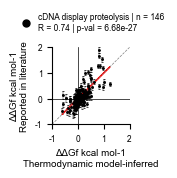

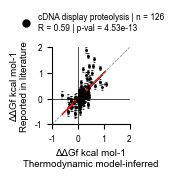

In [6]:
### SCALE VALUES TO MATCH IDENTITY LINE, STARTING FROM ADDITIVE TRAIT ###

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr
from matplotlib.lines import Line2D  # For adding custom legend markers
import math

plt.rcParams['font.family'] = 'Arial'

model_names = {'order1':'1', '2_sparse_regularized':'2_sparse_regularized'}
tasks = {'order1':'1', '2_sparse_regularized':'4'}

for mochi_model in model_names.keys():
    ## LOAD MODEL COEFFICIENTS ##
    coefs = pd.read_csv(path+'Fig5/mochi/Surface/RandomFYN_surface_order'+model_names[mochi_model]+'/task_'+tasks[mochi_model]+'/weights/weights_Folding.txt',
                               sep='\t')
    coefs.rename(columns={'ci95_kcal/mol': 'ci95_kcal_mol'}, inplace=True)
    for index, row in coefs.iterrows():
        if row.id_ref == 'WT':
            coefs.at[index, 'order'] = 0
        else:
            coefs.at[index, 'order'] = len(row.id.split('_'))
    
    firstorderterms = coefs.loc[coefs['order'] == 1].copy()
    
    rocklin_merge = firstorderterms[['id', 'mean', 'std', 'order']].merge(
        rocklin_query_protein.loc[rocklin_query_protein['redundant_single']==False][['mutations', 'deltaG', 'deltaG_95CI']], 
        left_on='id', right_on='mutations'
    )
    rocklin_merge.set_index('id', inplace=True)
    del rocklin_merge['mutations']
    
    rocklins_wt_dg = -1 * rocklin_query_protein.loc[rocklin_query_protein['name'] == '1A0N.pdb'].iloc[0]['deltaG']
    rocklins_wt_dg_SE = (-1 * rocklin_query_protein.loc[rocklin_query_protein['name'] == '1A0N.pdb'].iloc[0]['deltaG_95CI']) / 1.96
    alberts_wt_dg = float(coefs.loc[coefs['id'] == 'WT'].iloc[0]['mean'])
    for index, row in rocklin_merge.iterrows():
        variant_dg_SE = (-1 * row.deltaG_95CI) / 1.96
        variant_ddg_SE = math.sqrt((rocklins_wt_dg_SE**2) + (variant_dg_SE**2))
        rocklin_merge.at[index, 'rocklin_dGf'] = -1 * row.deltaG
        rocklin_merge.at[index, 'rocklin_ddGf'] = (-1 * row.deltaG) - rocklins_wt_dg
        rocklin_merge.at[index, 'rocklin_ddGf_SE'] = variant_ddg_SE
        rocklin_merge.at[index, 'rocklin_ddGf_CI95'] = variant_ddg_SE * 1.96
        rocklin_merge.at[index, 'albert_dGf'] = alberts_wt_dg + row['mean']
    
    thermomut_merge = firstorderterms[['id', 'mean', 'std','order']].merge(thermomut.loc[(thermomut['order'] == 1) & (thermomut['ΔΔG'].notna())][['ΔΔG','Mut1','order']], left_on='id',right_on='Mut1').drop_duplicates().set_index('Mut1').sort_values('mean').copy()
    if len(thermomut_merge)>0:
        thermomut_avg = pd.DataFrame()
        for index, row in thermomut_merge.value_counts('id').to_frame().iterrows():
            multiple_measurements = thermomut_merge.loc[thermomut_merge['id']==index]
            thermomut_avg.at[index,'id']=index
            thermomut_avg.at[index,'mean']=multiple_measurements.iloc[0]['mean']
            thermomut_avg.at[index,'std']=multiple_measurements.iloc[0]['std']
            thermomut_avg.at[index,'order_x']=multiple_measurements.iloc[0]['order_x']
            thermomut_avg.at[index,'ΔΔG']=multiple_measurements['ΔΔG'].mean()
            thermomut_avg.at[index,'iv_std']=multiple_measurements['ΔΔG'].std()
        thermomut_core = thermomut_avg[['ΔΔG','iv_std','mean','std','order_x']].copy()
        thermomut_core = thermomut_core.rename(columns={'ΔΔG':'prev_ddG','iv_std':'prev_SE','order_x':'Nham'})
        thermomut_core['Dataset']='ThermoMutDB'
    rocklin_merge = rocklin_merge.rename(columns={'rocklin_ddGf':'prev_ddG','rocklin_ddGf_SE':'prev_SE','order':'Nham'})
    rocklin_merge['Dataset']='cDNA display proteolysis'
    if len(thermomut_merge)>0:
        all_core_ddGf_validations = pd.concat([thermomut_core[['prev_ddG','prev_SE','mean','std','Dataset','Nham']],rocklin_merge[['prev_ddG','prev_SE','mean','std','Dataset','Nham']]],axis=0)
    else:
        all_core_ddGf_validations = rocklin_merge[['prev_ddG','prev_SE','mean','std','Dataset','Nham']].copy()

    fig, ax = plt.subplots(figsize=(1, 1))
    if len(thermomut_merge)>0:
        palette = {'ThermoMutDB': '#BB202E', 'cDNA display proteolysis': 'black'}
    else:
        palette = {'cDNA display proteolysis': 'black'}
    
    x = all_core_ddGf_validations[['mean']].to_numpy()
    y = all_core_ddGf_validations[['prev_ddG']].to_numpy()
    model = LinearRegression()
    model.fit(x, y)
    slope = model.coef_[0][0]
    intercept = model.intercept_[0]

    y_scaled = y
    x_scaled = slope * x + intercept

    model_scaled = LinearRegression()
    model_scaled.fit(x_scaled, y_scaled)
    y_pred_scaled = model_scaled.predict(x_scaled)

    sns.scatterplot(
        x=x_scaled.ravel(),
        y=y_scaled.ravel(),
        hue=all_core_ddGf_validations['Dataset'],
        palette=palette,
        ax=ax,
        s=0,
        edgecolor='k',
        linewidth=0.1
    )

    for dataset in palette.keys():
        mask = all_core_ddGf_validations['Dataset'] == dataset
        plt.errorbar(
            x_scaled[mask].ravel(), 
            y_scaled[mask].ravel(),
            yerr=all_core_ddGf_validations.loc[mask]['prev_SE'], 
            xerr=all_core_ddGf_validations.loc[mask]['std'] * slope,#(slope if slope > 1 else 1), 
            fmt='o',  # Ensure markers are displayed
            elinewidth=0.3, 
            capsize=1, 
            capthick=0.5, 
            markersize=1,  # Adjust marker size here
            linewidth=0, 
            color=palette[dataset], 
            label=''
        )

    plt.plot(x_scaled, y_pred_scaled, color='red', linewidth=1, linestyle='-')
    ax.axline((0, 0), slope=1, linestyle="dashed", color='gray', lw=0.5)
    ax.axhline(0, color='black', linewidth=0.5)
    ax.axvline(0, color='black', linewidth=0.5)
    r, p = pearsonr(y_scaled.ravel(), y_pred_scaled.ravel())
    if len(thermomut_merge)>0:
        ax.text(
            0.5,2, 
            f'All measurements | n = {len(x)}\nR = {round(r, 2)} | p-val = {p:.2e}', 
            fontsize=7, color='black', ha='center', va='center', transform=ax.transAxes
        )
    plt.xlabel('ΔΔGf kcal mol-1\nThermodynamic model-inferred', fontsize=7)
    plt.ylabel('ΔΔGf kcal mol-1\nReported in literature', fontsize=7)
    min_tick=-3
    max_tick=7
    step=1
    ax.set_xticks(np.arange(min_tick, max_tick, step))
    ax.set_xticklabels(np.arange(min_tick, max_tick, step), fontsize=6)
    ax.set_yticks(np.arange(min_tick, max_tick, step))
    ax.set_yticklabels(np.arange(min_tick, max_tick, step), fontsize=6)
    ax.spines[['right', 'top']].set_visible(False)
    ax.set_ylim(-1,2)
    ax.set_xlim(-1,2)

    handles, labels = scatter.get_legend_handles_labels()
    legend_labels = []
    for dataset in palette.keys():
        subset = all_core_ddGf_validations[all_core_ddGf_validations['Dataset'] == dataset]
        x_subset = subset[['mean']].to_numpy()
        y_subset = subset[['prev_ddG']].to_numpy()
        model.fit(x_subset, y_subset)
        y_pred_subset = model.predict(x_subset)
        r_subset, p_subset = pearsonr(y_subset.ravel(), y_pred_subset.ravel())
        legend_labels.append(f"{dataset} | n = {len(x_subset)}\nR = {round(r_subset, 2)} | p-val = {p_subset:.2e}")
    if len(thermomut_merge)>0:
        custom_markers = [
            Line2D([0], [0], marker='o', color=palette['ThermoMutDB'], markersize=5, linestyle=''),
            Line2D([0], [0], marker='o', color=palette['cDNA display proteolysis'], markersize=5, linestyle='')
        ]
    else:
        custom_markers = [
            Line2D([0], [0], marker='o', color=palette['cDNA display proteolysis'], markersize=5, linestyle='')
        ]
    legend = ax.legend(
        handles=custom_markers,
        labels=legend_labels,
        bbox_to_anchor=(0.5, 1.1),
        loc='lower center',
        fontsize=6,
        frameon=False,
        handletextpad=0.5,
        title='',
        title_fontsize=7
    )
    legend._legend_box.align = "center"
#    if mochi_model != '2':
#        plt.close()
    all_core_ddGf_validations['actual_ddGs']=x_scaled
    all_core_ddGf_validations['scaled_std']=all_core_ddGf_validations['std'].to_numpy() * slope
    all_core_ddGf_validations.drop_duplicates('actual_ddGs').to_csv(path+'FigS12/EBG_surface_layer_ddGs_scaled_from_additivetrait_order'+mochi_model+'.txt',sep='\t')

    secondorderterms=coefs.loc[coefs['order']==2].copy()
    if len(secondorderterms) > 0:
        secondorderterms['mutation1']='a'
        secondorderterms['mutation2']='a'
        for index,row in secondorderterms.iterrows():
            secondorderterms.at[index,'mutation1']=row.id.split('_')[0]
            secondorderterms.at[index,'mutation2']=row.id.split('_')[1]
        
        secondorderterms['scaled_ddGs']=secondorderterms['mean']*slope
        secondorderterms['scaled_ddG_std']=secondorderterms['std']*slope
        secondorderterms.to_csv(path+'FigS12/EBG_surface_layer_order'+mochi_model+'_secondorderterms_scaled_w_iv_values.txt',sep='\t')


## Panel C

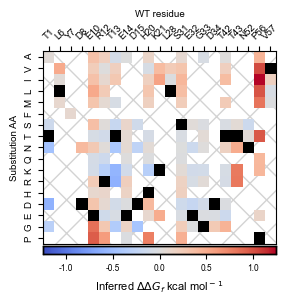

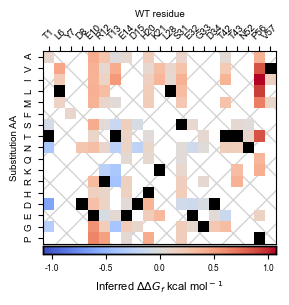

In [7]:
from matplotlib.patches import Rectangle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

model_names = {'order1':'1', '2_sparse_regularized':'2_sparse_regularized'}

for mochi_model in model_names.keys():
    all_core_ddGf_validations = pd.read_csv(path+'FigS12/EBG_surface_layer_ddGs_scaled_from_additivetrait_order'+mochi_model+'.txt',sep='\t',index_col=0)
    firstorderterms=all_core_ddGf_validations.drop_duplicates('actual_ddGs').copy()
    firstorderterms["mut_from"] = pd.Series(dtype="object") 
    firstorderterms["mut_from_aa"] = pd.Series(dtype="object") 
    firstorderterms["mut_to"] = pd.Series(dtype="object") 
    for index, row in firstorderterms.iterrows():
        firstorderterms.at[index,'mut_from']=index[0:-1]
        firstorderterms.at[index,'mut_from_aa']=index[0:1]
        firstorderterms.at[index,'mut_to']=index[-1]
        if row.name !='WT':
            firstorderterms.at[index,'mut_pos']=int(row.name[1:-1])
    
    firstorderterms=firstorderterms.sort_values('mut_pos',ascending=True)
    
    mutated_positions = []
    
    for index, row in firstorderterms.iterrows():
        if index !='WT' and row.mut_from not in mutated_positions:
            mutated_positions.append(row.mut_from)
    
    coefs_hm=pd.DataFrame(columns=mutated_positions)
    
    for index, row in firstorderterms.iterrows():
        if index !='WT':
            coefs_hm.at[row.mut_to,row.mut_from]=row.actual_ddGs

    coefs_hm = coefs_hm.reindex(['A', 'V', 'I', 'L', 'M', 'F', 'W', 'Y', 'S', 'T', 'C', 'N', 'Q', 'K', 'R', 'H', 'D', 'E', 'G', 'P', '-'])
    coefs_hm = coefs_hm.dropna(how='all')
            
    singles_boundary=abs(coefs_hm).fillna(0).to_numpy().max()
    fig, ax = plt.subplots(figsize=(3,2.5))
    cbar_ax=fig.add_axes([0.125,0.07,0.775,0.03])
    ax=sns.heatmap(coefs_hm.fillna(np.nan), mask=coefs_hm.fillna(np.nan).isnull(), cmap='coolwarm', xticklabels=True, yticklabels=True,cbar_kws={"orientation": "horizontal", "pad": 0.02, 'ticks':list(np.arange(-2,3,1))}, cbar_ax=cbar_ax,ax=ax,
                  vmax=singles_boundary,vmin=-1*singles_boundary, fmt= '', annot_kws={'size':4})
    ax.set_facecolor('white')
    ax.patch.set(hatch='x', edgecolor='#D3D3D3')
    #ax.figure.axes[-1].set_xticks(ticks=np.arange(-2,3,1),labels=np.arange(-2,3,1), fontsize=7)
    ax.figure.axes[-1].set_xlabel(r'Inferred ${ΔΔG_{f}}$ \ kcal mol$^-$$^1$', rotation=0, labelpad=5, fontsize=7)
    ax.tick_params(axis='both', which='both', labelsize=7, labelbottom = False, bottom=False, top = True, labeltop=True)
    ax.tick_params(axis='x', which='both', rotation=45)
    ax.set_xlabel('WT residue',  fontsize=7)
    ax.xaxis.set_label_position('top') 
    ax.set_ylabel('Substitution AA', fontsize=7)

    cbar_ax.set_xlabel(r'Inferred ${ΔΔG_{f}}$ kcal mol$^-$$^1$', rotation=0, fontsize=8)
    cbar_ax.xaxis.set_label_position('bottom')
    cbar_ax.set_xticks(np.arange(-1,1.5,0.5), [str(round(i,2)) for i in np.arange(-1,1.5,0.5)], fontsize=6)
    for spine in cbar_ax.spines.values():
        spine.set(visible=True,lw=1,edgecolor='black')
    
    for i in mutated_positions:
        for j in mutated_positions:
            if i[0]==j[0]:
                col=coefs_hm.columns.get_loc(i)
                try:
                    row=coefs_hm.index.get_loc(j[0])
                    ax.add_patch(Rectangle((col, row), 1, 1, fill=True, lw=0.0001, color='black'))
                except KeyError:
                    continue
                
    ax.spines[['left','bottom','top','right']].set_visible(True)
    plt.rcParams['svg.fonttype'] = 'none'
    #plt.savefig('EBG_surface_layer_2ndordersparsemodel_1storderterms_scaled_to_iv_values.png', dpi=300, bbox_inches = "tight")

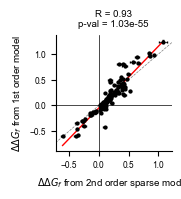

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

coefs_1storder = pd.read_csv(path+'FigS12/EBG_surface_layer_ddGs_scaled_from_additivetrait_orderorder1.txt',
                       sep='\t', index_col=0)

coefs_2ndorder_sprsreg = pd.read_csv(path+'FigS12/EBG_surface_layer_ddGs_scaled_from_additivetrait_order2_sparse_regularized.txt',
                       sep='\t', index_col=0)
coefs_1storder=coefs_1storder.rename(columns={'actual_ddGs':'ddGs_1storder','scaled_std':'std_1storder'})
coefs_2ndorder_sprsreg=coefs_2ndorder_sprsreg.rename(columns={'actual_ddGs':'ddGs_2ndordersparse','scaled_std':'std_2ndordersparse'})

weights_merger = coefs_2ndorder_sprsreg[['ddGs_2ndordersparse','std_2ndordersparse']].merge(coefs_1storder[['ddGs_1storder','std_1storder']], left_index=True, right_index=True)

from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error, r2_score

weights_merger=weights_merger.sort_values('ddGs_2ndordersparse')

x = weights_merger[['ddGs_2ndordersparse']].to_numpy()
y = weights_merger[['ddGs_1storder']].to_numpy()

model = LinearRegression()
model.fit(x, y)

y_pred = model.predict(x)
r2 = r2_score(y,y_pred)
r,p = pearsonr(y.ravel(),y_pred.ravel())

fig, ax=plt.subplots(figsize=(1.5,1.5))
ax.axline((0, 0), slope=1, linestyle="dashed", color='gray', lw=0.5)
ax.axhline(0, color='black', linewidth=0.5)
ax.axvline(0, color='black', linewidth=0.5)
plt.plot(x, y_pred, color='red', linewidth=1, linestyle='-')
ax.errorbar(weights_merger[['ddGs_2ndordersparse']].to_numpy().ravel(),weights_merger[['ddGs_1storder']].to_numpy().ravel(),weights_merger[['std_1storder']].to_numpy().ravel(),weights_merger[['std_2ndordersparse']].to_numpy().ravel(), color='k',linewidth=0,
           markersize=2,marker='o', capsize=0.5, elinewidth=0.5)
ax.set_xlabel(r'${ΔΔG_{f}}$ from 2nd order sparse model', fontsize=7)
ax.set_ylabel(r'${ΔΔG_{f}}$ from 1st order model', fontsize=7)
ax.spines[['top', 'right']].set_visible(False)
ax.tick_params(labelsize=6)
plt.title('R = '+str(round(r,2))+ '\np-val = '+'{:0.2e}'.format(p), fontsize=7)
plt.rcParams['svg.fonttype'] = 'none'
#plt.savefig('EBG_surface_1storder_vs_2ndordersparse_model_1storderterms.svg', dpi=300, transparent=True)


## Panel D

In [9]:
secondorderterms=pd.read_csv(path+'FigS12/EBG_surface_layer_order2_sparse_regularized_secondorderterms_scaled_w_iv_values.txt',sep='\t')

single_mutations=[]
for index, row in secondorderterms.iterrows():
    if row.mutation1 not in single_mutations:
        single_mutations.append(row.mutation1)
for index, row in secondorderterms.iterrows():
    if row.mutation2 not in single_mutations:
        single_mutations.append(row.mutation2)    
single_mutations=sorted(single_mutations, key=lambda x: (int(x[1:-1]), x[-1]) )

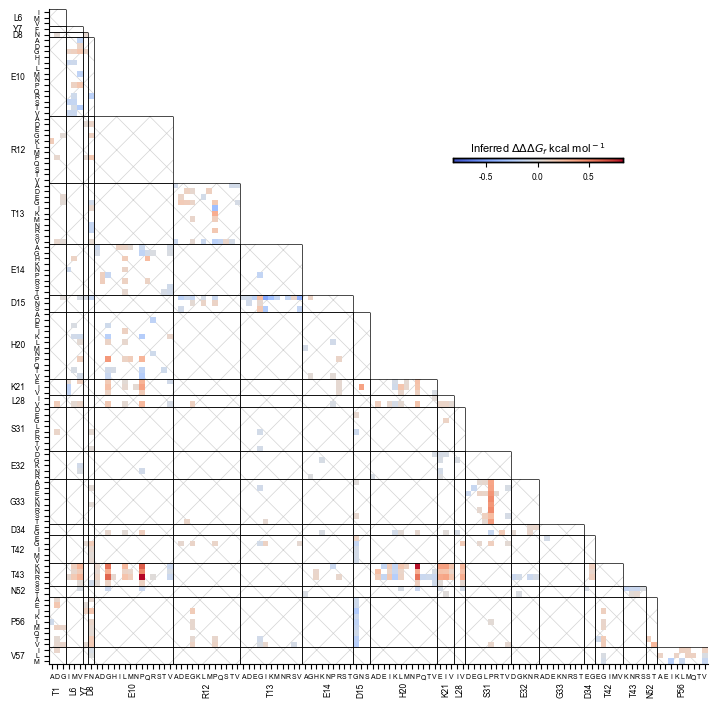

In [10]:
from matplotlib.patches import Rectangle
from matplotlib.patches import PathPatch
from matplotlib.path import Path
import seaborn as sns
import matplotlib.pyplot as plt
import math
from collections import Counter
import matplotlib as mpl
import numpy as np

plt.rcParams['font.family'] = 'Arial'

pairwise_secondorderterms=pd.DataFrame(columns=single_mutations)

for index, row in secondorderterms.iterrows():
    pairwise_secondorderterms.at[row.mutation1,row.mutation2]=row['mean']

for index, row in secondorderterms.iterrows():
    pairwise_secondorderterms.at[row.mutation2,row.mutation1]=row['mean']

pairwise_secondorderterms=pairwise_secondorderterms*slope
pairwise_secondorderterms=pairwise_secondorderterms.fillna(np.nan)
pairwise_secondorderterms=pairwise_secondorderterms.reindex(single_mutations)

#plt.figure(figsize=(10,8))
fig, ax=plt.subplots(figsize=(8.5,8.5))


mask = np.zeros_like(pairwise_secondorderterms.iloc[list(Counter([i[:-1] for i in single_mutations]).values())[0]:,:-1*list(Counter([i[:-1] for i in single_mutations]).values())[-1]], dtype=bool)

rowiterator=0
columniterator=0
for index, row in pairwise_secondorderterms.iloc[list(Counter([i[:-1] for i in single_mutations]).values())[0]:,:-1*list(Counter([i[:-1] for i in single_mutations]).values())[-1]].iterrows():
    for column in pairwise_secondorderterms.iloc[list(Counter([i[:-1] for i in single_mutations]).values())[0]:,:-1*list(Counter([i[:-1] for i in single_mutations]).values())[-1]].columns:
        if int(row.name[1:-1]) <= int(column[1:-1]):
            mask[rowiterator, columniterator]=True
            columniterator+=1
        else:
            mask[rowiterator, columniterator]=False
            columniterator+=1
    columniterator=0
    rowiterator+=1
    
mask



            
cbar_ax=fig.add_axes([0.6,0.7,0.2,0.005])

mpl.rcParams['hatch.linewidth'] = 0.5
ax.patch.set(hatch='x', edgecolor='#D3D3D3')
ax.patch.set_linewidth(0)
ax.set_facecolor('white')
couplings_boundary=abs(pairwise_secondorderterms).fillna(0).to_numpy().max()
hmap=sns.heatmap(pairwise_secondorderterms.iloc[list(Counter([i[:-1] for i in single_mutations]).values())[0]:,:-1*list(Counter([i[:-1] for i in single_mutations]).values())[-1]], cmap='coolwarm', center=0, xticklabels=True,yticklabels=True, mask=mask,vmin=-1*couplings_boundary, vmax=couplings_boundary,
              cbar_kws={"orientation": "horizontal", "pad": 0.02, 'ticks':list(np.arange(-2,3,1))}, ax=ax, cbar_ax=cbar_ax, fmt= '', annot_kws={'size':4})


#ax.figure.axes[-1].set_ylabel('ddG', rotation=270)
cbar_ax.set_xlabel(r'Inferred ${ΔΔΔG_{f}}$ kcal mol$^-$$^1$', rotation=0, fontsize=8)
cbar_ax.xaxis.set_label_position('top')
cbar_ax.set_xticks(np.arange(-0.5,1,0.5), [str(round(i,1)) for i in np.arange(-0.5,1,0.5)], fontsize=6)
for spine in cbar_ax.spines.values():
    spine.set(visible=True,lw=1,edgecolor='black')

    
labels_x = [item.get_text() for item in ax.get_xticklabels()]
for label_nr, label in enumerate(labels_x):
    labels_x[label_nr]=label[-1]
ax.set_xticklabels(labels_x, rotation=0,fontsize=5)
labels_y = [item.get_text() for item in ax.get_yticklabels()]
for label_nr, label in enumerate(labels_y):
    labels_y[label_nr]=label[-1]
ax.set_yticklabels(labels_y, rotation=0,fontsize=5)


start_row=0
start_col=0

codes= [Path.MOVETO, Path.LINETO]
for rows in enumerate(list(Counter([i[:-1] for i in single_mutations]).values())[1:]):
    for cols in enumerate(list(Counter([i[:-1] for i in single_mutations]).values())[:]):
        if rows[0]<cols[0]:
            rect = Rectangle((start_col, start_row), cols[1], rows[1], linewidth=0,facecolor='white')
            ax.add_patch(rect)
            if cols[0]-rows[0]==1:
                rx, ry = rect.get_xy()
                cx = rx + rect.get_width()
                cy = ry + rect.get_height()
                vertices=[(rx,ry), (rx, cy)]
                pth= Path(vertices, codes)
                line_patch = PathPatch(pth, lw=0.5, color='k')
                ax.add_patch(line_patch)
        else:
            rect = Rectangle((start_col, start_row), cols[1], rows[1], linewidth=0.5, edgecolor='black',facecolor='none')
            ax.add_patch(rect)
            
            rx, ry = rect.get_xy()
            cx = rx + rect.get_width()/2
            cy = ry + rect.get_height()/2
            if start_col == 0:
                ax.annotate(list(Counter([i[:-1] for i in single_mutations]).keys())[1:][rows[0]], (cx-7,cy), ha= 'center', va='center',fontsize=6, annotation_clip=False)
            if start_row == (sum(list(Counter([i[:-1] for i in single_mutations]).values())[1:])-rows[1]):
                ax.annotate(list(Counter([i[:-1] for i in single_mutations]).keys())[:][cols[0]], (cx,cy+6), ha= 'center', va='center',fontsize=6, annotation_clip=False, rotation=90)
        
            
        start_col=start_col+cols[1]
        
    start_col=0
    start_row=start_row+rows[1]

ax.spines[['left','bottom']].set_visible(True)
ax.spines[['top','right']].set_visible(False)
plt.rcParams['svg.fonttype'] = 'none'
#plt.savefig('EBG_surface_2ndorder_2ndorderterms.png', dpi=300, bbox_inches = "tight")